<a href="https://colab.research.google.com/github/engineerJPark/FCN_Implementation/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이미지 크기 어떻게 될지 살펴볼 것


https://github.com/wkentaro/pytorch-fcn/blob/ad22a47671140b2abc6712a0e004193fa382bc48/torchfcn/models/fcn16s.py#L78

dataset 참고할 것

https://pytorch.org/vision/stable/generated/torchvision.datasets.VOCSegmentation.html#torchvision.datasets.VOCSegmentation

COCO dataset

https://ndb796.tistory.com/667

VOC dataset

https://velog.io/@tataki26/open-cv

https://bo-10000.tistory.com/38

https://www.cognex.com/ko-kr/blogs/deep-learning/research/deep-learning-segmentation-finding-marking-dogs-cats-gcn

Label Accuracy Code
https://github.com/wkentaro/pytorch-fcn/blob/main/torchfcn/utils.py

Loss and Train Code
https://github.com/wkentaro/pytorch-fcn/blob/main/torchfcn/trainer.py

torch util file
https://github.com/wkentaro/pytorch-fcn/blob/main/torchfcn/utils.py

torch fcn util file
https://github.com/wkentaro/fcn/blob/main/fcn/utils.py

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import cv2
import os
import random
import xml.etree.ElementTree as ET


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
print(resnet_pretrained)

In [ ]:
# dataloader on PASCAL VOC
# use name as train_set, val_set, test_set
# segmentation label 0 = background
# 1 ~ 20 is object

!mkdir ./data
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar -C /content/data

img shape: (281, 500, 3)


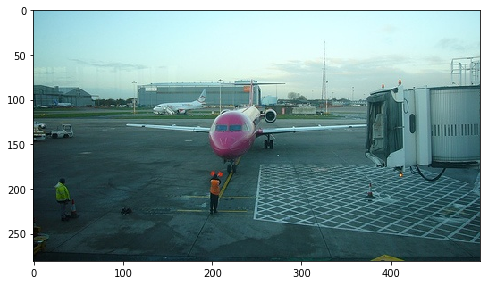

In [39]:
default_dir = '/content/data'
img = cv2.imread(os.path.join(default_dir, 'VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

img shape: (281, 500, 3)


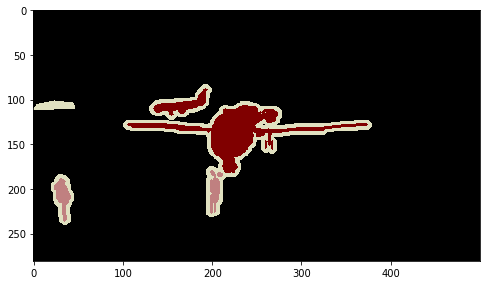

[0 0 0]
[  0   0 128]
[0 0 0]
[128   0   0]


In [40]:
img = cv2.imread(os.path.join(default_dir, 'VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

print(img[0][0])
print(img[141][250])
print(img_rgb[0][0])
print(img_rgb[141][250])

In [41]:
# !pip3 install lxml

VOC_ROOT_DIR ="/content/data/VOCdevkit/VOC2012/"
ANNO_DIR = os.path.join(VOC_ROOT_DIR, "Annotations")
IMAGE_DIR = os.path.join(VOC_ROOT_DIR, "JPEGImages")

xml_files = os.listdir(ANNO_DIR)
print(xml_files[:5]); print(len(xml_files))

['2011_001606.xml', '2008_003305.xml', '2011_006390.xml', '2010_001082.xml', '2009_002175.xml']
17125


In [42]:
xml_file = os.path.join(ANNO_DIR, '2007_000032.xml') # 아까 그 비행기 사진
tree = ET.parse(xml_file)
root = tree.getroot()

print(tree)
print(root)

image_name = root.find('filename').text
full_image_name = os.path.join(IMAGE_DIR, image_name)
image_size = root.find('size')
image_width = int(image_size.find('width').text)
image_height = int(image_size.find('height').text)

print(image_name,
full_image_name,
image_size,
image_width,
image_height)

<Element 'annotation' at 0x7fea50fd6950>
2007_000032.jpg /content/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg <Element 'size' at 0x7fea50fde650> 500 281


In [43]:
objects_list = []

for obj in root.findall('object'):
    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)
    
    bndbox_pos = (x1, y1, x2, y2)
    class_name=obj.find('name').text
    object_dict={'class_name': class_name, 'bndbox_pos':bndbox_pos}
    objects_list.append(object_dict)

print('full_image_name:', full_image_name,'\n', 'image_size:', (image_width, image_height))

for object in objects_list:
    print(object)

full_image_name: /content/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg 
 image_size: (500, 281)
{'class_name': 'aeroplane', 'bndbox_pos': (104, 78, 375, 183)}
{'class_name': 'aeroplane', 'bndbox_pos': (133, 88, 197, 123)}
{'class_name': 'person', 'bndbox_pos': (195, 180, 213, 229)}
{'class_name': 'person', 'bndbox_pos': (26, 189, 44, 238)}


In [44]:
os.path.join(VOC_ROOT_DIR, "JPEGImages", '2000' +'.jpg')

'/content/data/VOCdevkit/VOC2012/JPEGImages/2000.jpg'

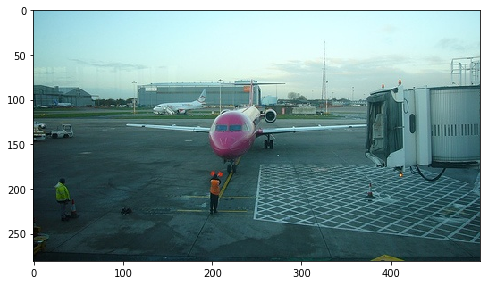

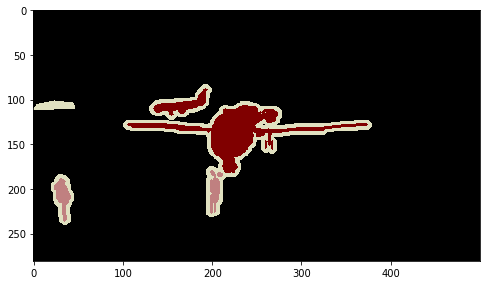

In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

def load_train_data():
  idx = 0
  with open("/content/data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt", 'r') as f:
    lines = f.readlines()
  for i in range(len(lines)):
    lines[i] =  lines[i].strip('\n')
  train_jpg = lines[idx] + '.jpg'
  train_gt_png = lines[idx] + '.png'

  train_img = cv2.imread(os.path.join(VOC_ROOT_DIR, "JPEGImages", train_jpg))
  train_gt_img = cv2.imread(os.path.join(VOC_ROOT_DIR, "SegmentationClass", train_gt_png))

  idx += 1

  return (train_img, train_gt_img)
    
train, train_gt = load_train_data()

train_rgb = cv2.cvtColor(train, cv2.COLOR_BGR2RGB)
train_gt_rgb = cv2.cvtColor(train_gt, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(train_rgb)
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(train_gt_rgb)
plt.show()

In [ ]:
# Bilinear weights deconvolution Algorithm 알아보기
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = (kernel_size + 1) // 2 - 1
  else:
    center = (kernel_size + 1) // 2 - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight


In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n):
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, 여기서 1x1 거친것 하나 추출
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, 여기서 1x1 거친것 하나 추출
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, 여기서 1x1 거친것 하나 추출

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)
    # nn.init.xavier_normal_(self.fully_conv_pool3.bias)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)
    # nn.init.xavier_normal_(self.fully_conv_pool4.bias)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    # nn.init.xavier_normal_(self.fully_conv_pool5.bias)
    
    # 보통 stride s, padding s/2, kernelsize 2s -> s배 만큼 이미지가 커진다.
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):
    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7)

    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

# model = FCN18(3)
# x = torch.rand([10, 3,1024,1024])
# print(model(x).shape)

In [ ]:
epochs = 10
lr = 10e-4
weight_decay = 2e-4
momentum = 0.9
batch_size = 20

model = FCN18(3)
optimizer = optim.SGD(model.paramters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

def loss_func(self, inputs, targets):
  '''
  cross entropy to each feature vector
  inputs shape : (N, C, H, W)
  targets shape : (N, C, H, W)
  만약 tragets가 (N, H, W)이라면 : target.view(n, h, w, 1).repeat(1, 1, 1, c)
  '''
  feature_vector = F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1) # output a feature vector : shape is (channel, )
  return feature_vector.mean()

def train():
  for epoch in range(epochs):
    for train_img, train_gt_img in train_set:
      score_img = model(train_img)
      loss = loss_func(score_img, train_gt_img)

      optimizer.zero_grad()
      optimizer.step()
      loss.backward()
    print("epoch %d, loss : %f "%(epoch + 1, loss))
  print("Training End")
  # validation
  # visualization